# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Подключаем библиотеки
from google.colab import drive
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
import plotly.express as px # для построения графиков
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # импорт метрик для оценки качества регрессионных моделей из библиотеки scikit-learn
from sklearn.linear_model import LinearRegression # импортирт класса LinearRegression из модуля linear_model библиотеки scikit-learn

%matplotlib inline

Прочитаем исходные данные:

In [2]:
# Монтируем Google Диск
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Andrew_learning/unconv.csv')
df.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов.

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [4]:
# Выведим основную информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [5]:
# Размерность датасета
df.shape

(200, 8)

In [6]:
# Сводная статистика по датасету
df.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


In [7]:
# Проверка отсутствующих значений
pd.isna(df).sum()[pd.isna(df).sum() > 0]

,0


**Построим графики распределение добычи газа в сутки (млн. кубических футов) в зависимости от характеристик скважины**

In [8]:
# Признаки для анализа зависимости с целевой переменной Prod
features = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']

# Создаем графики рассеяния
for feature in features:
    fig = px.scatter(df, x=feature, y='Prod', trendline="ols",
                     title=f'Зависимость добычи газа (Prod) от {feature}')
    fig.show()

**Вывод:**<br>
* в датасете 200 записей, 8 признаков (числовой тип);
* пропущенные значения отсутствуют;
* построенные графики распределение добычи газа в сутки (млн. кубических футов) в зависимости от характеристик скважины данных показали следующие результаты:
* график зависимости добычи газа (Prod) от Por (пористости) показал, что более пористые породы связаны с высокой добычей газа;
* график зависимости добычи газа (Prod) от Perm (проницаемости) показал, что чем выше проницаемость, тем больше добыча газа;
* график зависимости добычи газа (Prod) от AI (акустический импеданс) показал, что при увеличении AI добыча газа уменьшается, т.к. высокий акустический импеданс может свидетельствовать о плотной породе, менее пригодной для добычи;
* график зависимости добычи газа (Prod) от Brittle (коэффициент хрупкости) показал, что связь между данными параметрами слабая;
* график зависимости добычи газа (Prod) от TOC (общий органический углерод) показал, что породы с низким значения ТОС менее пригодны для добычи газа, а с более высоким значением являются хорошими источниками газа;
* график зависимости добычи газа (Prod) от VR (коэффициент отражения витринита) показал, чем выше зрелость органического вещества (VR), тем больше газа может быть добыто.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак.

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты.

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных?
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**):
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы.

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

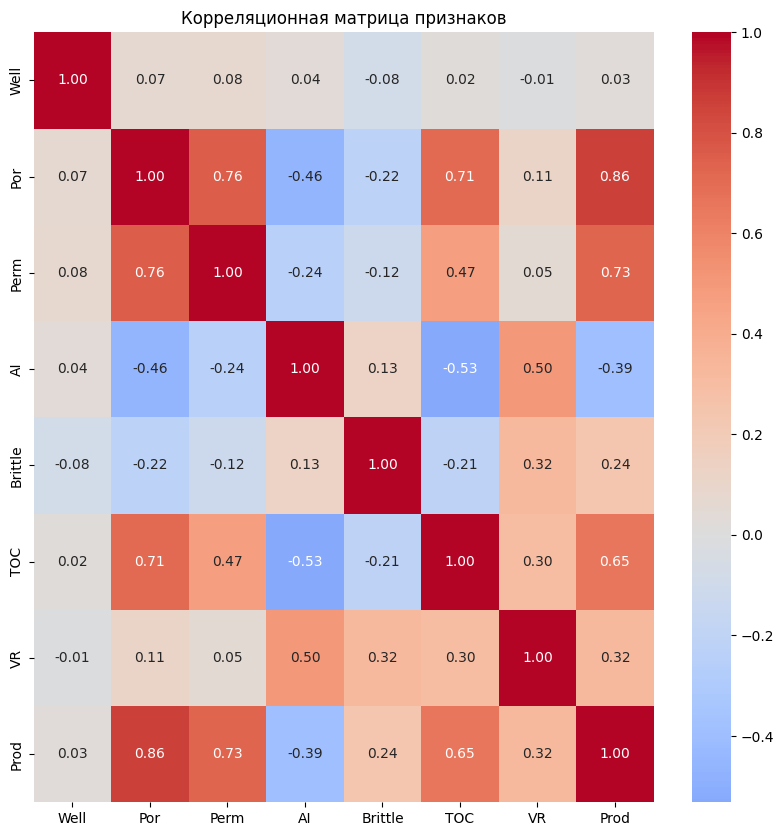

Ранг корреляционной матрицы: 8
Определитель корреляционной матрицы: 0.000729938807265181


In [9]:
# Загружаем данные
A = df

# Выполняем стандартизацию данных (центрирование и нормализация по стандартному отклонению)
A_st = (A - A.mean(axis=0)) / A.std(axis=0)

# Вычисляем матрицу корреляции
cor_matrix = A_st.corr()

# Создаем график - корреляционная матрица признаков
plt.figure(figsize=(10, 10))
sns.heatmap(cor_matrix, fmt=".2f", annot=True, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица признаков")
plt.show()

print("Ранг корреляционной матрицы:", np.linalg.matrix_rank(cor_matrix))
print("Определитель корреляционной матрицы:", np.linalg.det(cor_matrix))

> **Выводы:**<br>
* Пористость (Por) и проницаемость (Perm) скважины имеют наибольшую корреляцию с целевой переменной, что указывает на их сильное влияние на добычу газа;
* Ранг корреляционной матрицы составляет 8, что совпадает с количеством факторов, следовательно, все признаки линейно независимы, и матрица является полной по рангу;
* Однако определитель матрицы близок к нулю, что говорит о её плохой обусловленности или почти вырожденности;
* Несмотря на максимальный ранг, низкий определитель указывает на наличие мультиколлинеарности между признаками;
* В таких условиях стандартная линейная регрессия (МНК) плохо подходит для моделирования, так как плохо обусловленные матрицы могут вызывать вычислительные ошибки. При нахождении обратной матрицы возникает риск больших числовых погрешностей, так как элементы обратной матрицы будут стремиться к бесконечности.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки.

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy.

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**):
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [10]:
# Создаём матрицу наблюдений X и вектор целевой переменной y
X_ = np.column_stack((
    np.ones(df.shape[0]),  # добавляем столбец единиц
    df.iloc[:, :-1].values
))

y_ = df['Prod']  # целевая переменная

# Вычисляем OLS-оценку для коэффициентов без стандартизации
w_hat_ = np.linalg.inv(X_.T @ X_) @ X_.T @ y_

# Составляем датафрейм с округлёнными коэффициентами
w_hat_df_ = pd.DataFrame(
    data=np.round(w_hat_.astype(int)),
    index=np.hstack((['Intercept'], np.array(df.columns[:-1]))),  # создаём индексы для коэффициентов
    columns=['Coefficients']  # столбец с названием 'Coefficients'
)

# Выводим результаты
w_hat_, w_hat_df_

(array([-1.23230803e+03,  5.07003631e-02,  2.30179140e+02,  1.16239006e+02,
        -3.65202301e+02,  2.49943700e+01, -7.84009294e+01,  7.85259815e+02]),
            Coefficients
 Intercept         -1232
 Well                  0
 Por                 230
 Perm                116
 AI                 -365
 Brittle              24
 TOC                 -78
 VR                  785)

> **Выводы:**<br>
* в представленных данных признак Well (идентификатор скважины) является неинформативным, т.к. его коэффициент равен 0, следовательно он не оказывает влияния на целевую переменную.
* коэффициент 230 при признаке Por (пористость скважины) показывает прямую зависимость с целевой переменной, т.е. при росте показателя пористости на 1% добыча газа увеличивается на 230 млн.куб.футов.
* показатель акустического импендаса оказывает обратный эффект: при его повышении на 1 $кг/м^2 * 10^6$ добыча газа снижается на 365 млн.куб.футов.


### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной.

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день.

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**):
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [11]:
# Добавляем единичный столбец в X для учета интерсепта (свободного члена)
X = np.column_stack((np.ones(len(df)), df.drop('Prod', axis=1).values))

# Целевая переменная
y = df['Prod'].values  # Преобразуем в одномерный массив

# Оценка коэффициентов линейной регрессии (метод наименьших квадратов)
w_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Определяем новые входные данные для прогнозирования
new_data = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
}

# Истинное значение выработки для новой скважины
y_new = 4748.315024

# Преобразуем новые данные в Pandas DataFrame и добавляем единичный столбец
new_data = pd.DataFrame([new_data])
new_data = np.array([1] + list(new_data.iloc[0]))  # Добавляем 1 для интерсепта

# Предсказание для новой скважины
y_pred_new = np.dot(new_data, w_hat)

print(f'Прогноз выработки газа, фут^3/день: {y_pred_new:.5f}')
print(f'Абсолютная ошибка выработки газа, фут^3/день: {np.round(np.abs(y_new - y_pred_new), 5)}')

# Строим прогноз для всего набора данных
y_pred = np.dot(X, w_hat)

# Вычисляем метрики качества модели
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred) * 100  # Переводим в проценты

print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f} %')

Прогноз выработки газа, фут^3/день: 4723.06405
Абсолютная ошибка выработки газа, фут^3/день: 25.25097
MAE: 153.62
MAPE: 3.63 %


> **Выводы:**<br>
1. Прогноз выработки газа для новой скважины - 4723.06405 фут^3/день, при фактическом значении 4748.315024 фут^3/день;
2. Абсолютная ошибка выработки газа - 25.25 фут^3/день, ошибка не очень большая, что говорит о высокой точности предсказания для рассматриваемой скважины;
3. Средняя абсолютная ошибка (MAE) - 153.62 фут^3/день, ошибка не очень большая, что является приемлемым результатом;
4. Средняя абсолютная процентная ошибка (MAPE) - 3.63%, что означает, что
в среднем предсказания модели отклоняются от реальных значений всего на 3.63%, что говорит о хорошей точности модели.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**).

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [12]:
# Выведим корреляционную матрицу для всех признаков в датасете, которая поможет выявить взаимосвязи между признаками и целевой переменной (Prod)
display(df.corr())

# Выведим коэффициенты линейной регрессии без интерсепта (w_0), которые показывают вклад каждого признака в предсказание целевой переменной)
print(np.round(w_hat_[1:].T, 2))

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


[ 5.0000e-02  2.3018e+02  1.1624e+02 -3.6520e+02  2.4990e+01 -7.8400e+01
  7.8526e+02]


> **Выводы:**<br>
1. Анализ корреляционной матрицы показал насколько сильно переменные связаны между собой и с целевой переменной Prod (добыча газа в сутки).
Согласно полученным результатам:
* параметр Por (пористость скважины) имеет самую высокую корреляция с Prod (0.86), т.е. увеличение пористости приводит к увеличению добычи газа;
* параметр Por (пористость скважины) имеет высокую корреляцию с параметрами Perm (0.76) и TOC (0.71), таким образом данные параметры тоже могут влиять на добычу газа;
* параметр Perm (проницаемость скважины) имеет высокую корреляция с Prod (0.73), т.е более проницаемые пласты способствуют более высокой добыче газа;
* параметр AI (акустический импеданс) имеет отрицательную связь с Prod (-0.39), т.е высокий акустический импеданс может свидетельствовать о плотной породе, менее пригодной для добычи газа;
* параметр Brittle (коэффициент хрупкости скважины) имеет слабую положительную связь с Prod (0.24), т.е более хрупкие породы могут немного увеличивать добычу газа;
* параметр TOC (общий органический углерод) имеет положительную связь с Prod (0.65), т.к породы с более высоким значением ТОС являются хорошими источниками газа;
* параметр VR (коэффициент отражения витринита) имеет положительную связь с Prod (0.32), т.е чем выше зрелость органического вещества (VR), тем больше газа может быть добыто.

2. Анализ коэффициентов линейной регрессии (w_hat_) показывает вклад каждого признака в предсказание целевой переменной Prod.
Солгласно полученным результатам:
* параметр Por (пористость скважины) имеет очень сильное влияние на Prod, т.е. увеличение пористости приводит к увеличению добычи газа;
* параметр Perm (проницаемость скважины) имеет значительное влияние на Prod, т.е рост проницаемости увеличивает добычу газа;
* параметр AI (акустический импеданс) имеет сильное отрицательное влияние на Prod, т.е рост AI снижает добычу газа;
* параметр Brittle (коэффициент хрупкости скважины) имеет незначительное влияние на Prod;
* параметр TOC (общий органический углерод) имеет отрицательное влияние на на Prod, что противоречит данным полученным на основе анализа корреляционной матрицы, где влияние положительное и зависимость между ТОС и целевой переменной Prod прямая. Таким образом, данное противоречие показывает, что присутствует мультиколлинеарность между признаками;
* параметр VR (коэффициент отражения витринита) имеет самое сильное влияние, т.к рост VR сильно увеличивает добычу газа.


### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики).

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее.
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**):
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [13]:
# Формируем матрицу наблюдений X_1 и целевую переменную y_1
X_1 = np.column_stack((np.ones(df.shape[0]), df.drop(['Prod', 'Well', 'Perm', 'TOC'], axis=1)))
y_1 = df[['Prod']]

# Вычисляем вектор коэффициентов методом наименьших квадратов (OLS)
w_hat_1 = np.linalg.inv(X_1.T @ X_1) @ X_1.T @ y_1
print("Коэффициенты линейной регрессии:")
print(np.round(w_hat_1).astype(int))

# Делаем прогноз для всех данных
y_pred_1 = X_1 @ w_hat_1

# Вычисляем метрики качества модели
mae = mean_absolute_error(y, y_pred_1)
mape_score = mean_absolute_percentage_error(y_1, y_pred_1) * 100
print(f'MAE: {mae:.2f}')
print(f'MAPE score: {mape_score:.1f} %')

# Выводим корреляционную матрицу оставшихся признаков
print("\nКорреляционная матрица оставшихся признаков:")
print(df.drop(['Well', 'Perm', 'TOC'], axis=1).corr())

# Выводим коэффициенты без intercept
print("\nКоэффициенты без intercept:")
print(np.round(w_hat_1[1:].T.astype(int)))

Коэффициенты линейной регрессии:
   Prod
0 -1835
1   293
2  -200
3    28
4   517
MAE: 171.43
MAPE score: 4.0 %

Корреляционная матрица оставшихся признаков:
              Por        AI   Brittle        VR      Prod
Por      1.000000 -0.461549 -0.218570  0.111860  0.861910
AI      -0.461549  1.000000  0.127599  0.499143 -0.390835
Brittle -0.218570  0.127599  1.000000  0.317929  0.237155
VR       0.111860  0.499143  0.317929  1.000000  0.323182
Prod     0.861910 -0.390835  0.237155  0.323182  1.000000

Коэффициенты без intercept:
        1    2   3    4
Prod  293 -200  27  517


> **Выводы:**<br>
В результате исключения сильно коррелированных между собой признаков получили следующие результаты:
1. Анализ корреляционной матрицы оставшихся признаков:
* параметр Por (пористость скважины) имеет самую высокую корреляция с Prod (0.86), т.е. увеличение пористости приводит к увеличению добычи газа;
* параметр AI (акустический импеданс) имеет отрицательную связь с Prod (-0.39), т.е высокий акустический импеданс может свидетельствовать о плотной породе, менее пригодной для добычи газа;
* параметр Brittle (коэффициент хрупкости скважины) имеет слабую положительную связь с Prod (0.24), т.е более хрупкие породы могут немного увеличивать добычу газа;
* параметр VR (коэффициент отражения витринита) имеет положительную связь с Prod (0.32), т.е чем выше зрелость органического вещества (VR), тем больше газа может быть добыто.
2. Анализ коэффициентов линейной регрессии:
* параметр Por (пористость скважины) имеет очень сильное влияние на Prod, т.е. увеличение пористости приводит к увеличению добычи газа;
* параметр AI (акустический импеданс) имеет сильное отрицательное влияние на Prod, т.е рост AI снижает добычу газа, в ранее рассчитаной модели коэффицент был меньше и составлял -365 (сейчас -200).
* параметр Brittle (коэффициент хрупкости скважины) имеет незначительное влияние на Prod, в ранее рассчитаной модели коэффицент был меньше и составлял 24 (сейчас 27);
* параметр VR (коэффициент отражения витринита) имеет самое сильное влияние, т.к рост VR сильно увеличивает добычу газа, в ранее рассчитаной модели коэффицент был больше и составлял 785 (сейчас 517);
3. Средняя абсолютная ошибка (MAE) увеличилась стало 171.43 фут^3/день, было 153.62 фут^3/день, ошибка не очень большая, что является приемлемым результатом;
4. Средняя абсолютная процентная ошибка (MAPE) также увеличилась стало 4,0%, было 3.63%, что означает, что в среднем предсказания модели отклоняются от реальных значений всего на 4%, что говорит о хорошей точности модели.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**):
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [14]:
# Формируем матрицу признаков X, удаляя ненужные колонки, и целевую переменную y
X = df.drop(['Prod', 'Perm', 'TOC', 'Well'], axis=1)
y = df['Prod'].values

# Создаём и обучаем модель линейной регрессии из sklearn
LR = LinearRegression()
LR.fit(X, y)

# Делаем предсказание
y_pred = LR.predict(X)

# Вычисляем метрики качества модели
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred) * 100  # В процентах

# Выводим полученные коэффициенты модели, округляя до целого числа
print("Коэффициенты модели sklearn:", np.round(LR.coef_).astype(int))

# Выводим коэффициенты из ранее рассчитанной модели без intercept
print("Коэффициенты из ранее рассчитанной модели (без intercept):", np.round(w_hat_1[1:]).astype(int))

# Выводим метрики
print(f"MAE: {mae:.2f}")
print(f"MAPE score: {mape:.1f} %")


Коэффициенты модели sklearn: [ 293 -200   28  517]
Коэффициенты из ранее рассчитанной модели (без intercept):    Prod
1   293
2  -200
3    28
4   517
MAE: 171.43
MAPE score: 4.0 %


> **Выводы:**<br>
В результате мы получили идентичные результаты с предыдущим шагом, что свидетельствует о равнозначности ручного расчёта и использования библиотечной реализации.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию.

Приступим! Выполните задания 8.1–8.5:


In [15]:
# Импорт необходимых библиотек
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`.

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**):
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [16]:
# Инициализируем стандартизатор StandardScaler
scaler = StandardScaler()

# Проводим нормализацию данных
X_scaled = scaler.fit_transform(X)

# Создаём полиномиальные признаки степени 3
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)  # Генерация новых полиномиальных признаков
print(f'Размерность X_poly после трансформации: {X_poly.shape}')

# Обучаем модель линейной регрессии на полиномиальных признаках
LR = LinearRegression()
LR.fit(X_poly, y)

# Оцениваем качество модели с помощью кросс-валидации (5 фолдов)
cv_results = cross_validate(
    LR, X_poly, y, scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'], cv=5, return_train_score=True
)

# Рассчитываем средние метрики MAPE и MAE на обучающей и валидационной выборках
LR_train_mape = round(-cv_results['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)
LR_test_mape = round(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)
LR_train_mae = round(-cv_results['train_neg_mean_absolute_error'].mean(), 2)
LR_test_mae = round(-cv_results['test_neg_mean_absolute_error'].mean(), 2)
print(f'MAPE на тренировочных фолдах: {LR_train_mape:.2f}%')
print(f'MAPE на валидационных фолдах: {LR_test_mape:.2f}%')
print(f'MAE на тренировочных фолдах: {LR_train_mae:.2f}')
print(f'MAE на валидационных фолдах: {LR_test_mae:.2f}')

Размерность X_poly после трансформации: (200, 34)
MAPE на тренировочных фолдах: 1.77%
MAPE на валидационных фолдах: 2.68%
MAE на тренировочных фолдах: 75.35
MAE на валидационных фолдах: 110.47


> **Выводы:**<br>
1. После создания полиномиальных признаков размерность данных увеличилась с исходного количества (8 признаков) до 34 признаков, что говорит нам о том, что модель теперь использует более сложные зависимости между признаками.
2. Анализ качества модели на обучающих и валидационных данных показал, что
разница между тренировочным и тестовым MAPE (1.77% => 2.68%) и MAE (75.35 => 110.47) относительно небольшая, что говорит о достаточно хорошем балансе модели.Если сравнивать ранее полученные результаты и нынешние значения метрик, то переход к стандартизованным полиномиальным коэффициентам значительно улучшил модель и сократил перетренированность модели.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы.

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**):
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [18]:
# Определяем сетку гиперпараметров для Lasso-регрессии (значения альфа)
param = {'alpha': [0.1, 0.2, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20]}

# Инициализируем модель Lasso
lasso = Lasso()

# Настраиваем GridSearchCV для подбора оптимального параметра alpha
grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1
)

# Обучаем модель на полиномиальных признаках
grid_search.fit(X_poly, y)

# Выводим лучший найденный параметр alpha
best_alpha = grid_search.best_params_['alpha']
print("Оптимальное значение alpha:", best_alpha)

# Обучаем Lasso-регрессию с найденным значением alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_poly, y)

# Оцениваем модель с помощью кросс-валидации
cv_results = cross_validate(
    lasso, X_poly, y,
    scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
    cv=5, return_train_score=True
)

# Вычисляем MAPE и MAE на обучающей и валидационной выборках
lasso_train_mape = round(-cv_results['train_neg_mean_absolute_percentage_error'].mean() * 100, 3)
lasso_test_mape = round(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100, 3)
lasso_train_mae = round(-cv_results['train_neg_mean_absolute_error'].mean(), 3)
lasso_test_mae = round(-cv_results['test_neg_mean_absolute_error'].mean(), 3)
print(f'MAPE на тренировочных фолдах: {lasso_train_mape:.2f}%')
print(f'MAPE на валидационных фолдах: {lasso_test_mape:.2f}%')
print(f'MAE на тренировочных фолдах: {lasso_train_mae:.2f}')
print(f'MAE на валидационных фолдах: {lasso_test_mae:.2f}')


Оптимальное значение alpha: 5
MAPE на тренировочных фолдах: 1.83%
MAPE на валидационных фолдах: 2.28%
MAE на тренировочных фолдах: 78.30
MAE на валидационных фолдах: 95.69


> **Выводы:**<br>
1. Найдено оптимальное значение коэффициента регуляризации (alpha) = 5  методом GridSearchCV, которое обеспечивает наилучший баланс между точностью модели и регуляризацией.
2.  Анализ качества модели на тренировочных и валидационных данных показал, что
разница между тренировочным и валидационном MAPE (1.83% => 2.28%) и MAE (78.30 => 95.69) относительно небольшая, что говорит о достаточно хорошем балансе модели.
3. Полиномиальная регрессия с L1-регуляризацией ухудшила нашу метрику на тренировочном наборе данных (по сравнению с предыдущим шагом), но в то же время улучшила на валидационных данных, т.е сократилась разница между метриками.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы.

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**):
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [19]:
# Определяем сетку гиперпараметров для Ridge-регрессии (значения альфа)
param = {'alpha': [0.1, 0.2, 0.3, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 10, 15, 20]}

# Инициализируем модель Ridge
ridge = Ridge()

# Настраиваем GridSearchCV для подбора оптимального параметра alpha
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1
)

# Обучаем модель на полиномиальных признаках
grid_search.fit(X_poly, y)

# Выводим лучший найденный параметр alpha
best_alpha = grid_search.best_params_['alpha']
print("Оптимальное значение alpha:",  best_alpha)

# Обучаем Ridge-регрессию с найденным значением alpha
ridge = Ridge(alpha=grid_search.best_params_['alpha'])
ridge.fit(X_poly, y)

# Оцениваем модель с помощью кросс-валидации
cv_results = cross_validate(
    ridge, X_poly, y, scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'], cv=5, return_train_score=True
)

# Вычисляем MAPE и MAE на обучающей и валидационной выборках
ridge_train_mape = round(-cv_results['train_neg_mean_absolute_percentage_error'].mean() * 100, 3)
ridge_test_mape = round(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100, 3)
ridge_train_mae = round(-cv_results['train_neg_mean_absolute_error'].mean(), 2)
ridge_test_mae = round(-cv_results['test_neg_mean_absolute_error'].mean(), 2)
print(f'MAPE на тренировочных фолдах: {ridge_train_mape:.2f}%')
print(f'MAPE на валидационных фолдах: {ridge_test_mape:.2f}%')
print(f'MAE на тренировочных фолдах: {ridge_train_mae:.2f}')
print(f'MAE на валидационных фолдах: {ridge_test_mae:.2f}')


Оптимальное значение alpha: 0.2
MAPE на тренировочных фолдах: 1.77%
MAPE на валидационных фолдах: 2.67%
MAE на тренировочных фолдах: 75.40
MAE на валидационных фолдах: 110.07


> **Выводы:**<br>
1. Найдено оптимальное значение коэффициента регуляризации (alpha) = 0.2  методом GridSearchCV, которое обеспечивает наилучший баланс между точностью модели и регуляризацией.
2.  Анализ качества модели на тренировочных и валидационных данных показал, что
разница между тренировочным и валидационном MAPE (1.77% => 2.67%) и MAE (75.40 => 110.07) относительно небольшая, что говорит о достаточно хорошем балансе модели.
3. Полиномиальная регрессия с L2-регуляризацией отработала хуже, чем с L1-регуляризацией. Разница между метриками на тренировочных и валидационных данных увеличилась, при этом метрика на валидационном наборе данных стала хуже.

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы.

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**):
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [21]:
# Определяем сетку гиперпараметров для ElasticNet (alpha и l1_ratio)
param = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 1, 1.5, 2, 3, 4, 5],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Инициализируем модель ElasticNet
elastic_net = ElasticNet()

# Настраиваем GridSearchCV для подбора оптимальных параметров
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param,
    scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
    cv=5,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

# Обучаем модель на полиномиальных признаках
grid_search.fit(X_poly, y)

# Выводим лучшие найденные параметры alpha и l1_ratio
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
print(f"Оптимальные параметры: alpha={best_alpha}, l1_ratio={best_l1_ratio}")

# Обучаем ElasticNet с найденными оптимальными параметрами
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
elastic_net.fit(X_poly, y)

# Оцениваем модель с помощью кросс-валидации
cv_results = cross_validate(
    elastic_net, X_poly, y,
    scoring=['neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
    cv=5, return_train_score=True
)

# Рассчитываем MAPE и MAE на обучающей и валидационной выборках
mape_train = round(-cv_results['train_neg_mean_absolute_percentage_error'].mean() * 100, 3)
mape_test = round(-cv_results['test_neg_mean_absolute_percentage_error'].mean() * 100, 3)
mae_train = round(-cv_results['train_neg_mean_absolute_error'].mean(), 3)
mae_test = round(-cv_results['test_neg_mean_absolute_error'].mean(), 3)
print(f'MAPE на тренировочных фолдах: {mape_train:.2f}%')
print(f'MAPE на валидационных фолдах: {mape_test:.2f}%')
print(f'MAE на тренировочных фолдах: {mae_train:.2f}')
print(f'MAE на валидационных фолдах: {mae_test:.2f}')


Оптимальные параметры: alpha=5, l1_ratio=1
MAPE на тренировочных фолдах: 1.83%
MAPE на валидационных фолдах: 2.28%
MAE на тренировочных фолдах: 78.30
MAE на валидационных фолдах: 95.69


> **Выводы:**<br>
1. Найдены оптимальные значения коэффициентов регуляризации: alpha=5, l1_ratio=1;
2. Обучив модель ElasticNet из библиотеки sklearn получили, что итоговая модель представляет собой L1-регуляризацию  и демонстрирует идентичные значения метрик на тренировочных и валидационных данных.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**):
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [22]:
# Данные с результатами моделей
results = [
    ["Linear Regression", "", True, 1.77, 2.68, 75.35, 110.47],
    ["Lasso Regression", "alpha=5", True, 1.83, 2.28, 78.30, 95.69],
    ["Ridge Regression", "alpha=0.2", True, 1.77, 2.67, 75.40, 110.07],
    ["ElasticNet", "alpha=5, l1_ratio=1", True, 1.83, 2.28, 78.30, 95.70],
]

# Создаем таблицу
columns = [
    "Наименование модели",
    "Гиперпараметры",
    "Полиномиальные признаки",
    "MAPE (Train) %",
    "MAPE (Validation) %",
    "MAE (Train)",
    "MAE (Validation)",
]

df_results = pd.DataFrame(results, columns=columns)

print(df_results)

  Наименование модели       Гиперпараметры  Полиномиальные признаки  \
0   Linear Regression                                          True   
1    Lasso Regression              alpha=5                     True   
2    Ridge Regression            alpha=0.2                     True   
3          ElasticNet  alpha=5, l1_ratio=1                     True   

   MAPE (Train) %  MAPE (Validation) %  MAE (Train)  MAE (Validation)  
0            1.77                 2.68        75.35            110.47  
1            1.83                 2.28        78.30             95.69  
2            1.77                 2.67        75.40            110.07  
3            1.83                 2.28        78.30             95.70  


> **Выводы:**<br>
На основе проведенного анализа данных компании «Газ-Таз-Ваз-Нефть» было выявлено, что на объем добычи газа (целевой признак Prod) в скважине наиболее существенно влияют четыре признака: 'Por', 'AI', 'Brittle', 'VR'. Обучив несколько различных моделей для предсказания суточной добычи газа, пришли к выводу, что наилучшими вариантами являются модели Lasso Regression и ElasticNet. Данные модели дали лучший результат на валидационных данных (MAPE = 2.28%), но с небольшим ухудшением на тренировочных данных. Ни одна из моделей не является переобученной.